In [ ]:
! pip install nnfs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data

nnfs.init()

In [ ]:
# Dense layer
class Layer_Dense:

    # Layer initialization
    def __init__(self, n_inputs, n_neurons):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)

In [ ]:
# ReLU activation
class Activation_ReLU:

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)

    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify original variable,
        # let's make a copy of values first
        self.dinputs = dvalues.copy()

        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0

In [ ]:
# Softmax activation
class Activation_Softmax:

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs

        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1,
                                            keepdims=True))
        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1,
                                            keepdims=True)

        self.output = probabilities

    # Backward pass
    def backward(self, dvalues):

        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in \
                enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - \
                              np.dot(single_output, single_output.T)
            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix,
                                         single_dvalues)


In [ ]:
# SGD optimizer
class Optimizer_SGD:

    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate, decay, momentum):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If we use momentum
        if self.momentum:

            # If layer does not contain momentum arrays, create them
            # filled with zeros
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                # If there is no momentum array for weights
                # The array doesn't exist for biases yet either.
                layer.bias_momentums = np.zeros_like(layer.biases)

            # Build weight updates with momentum - take previous
            # updates multiplied by retain factor and update with
            # current gradients
            weight_updates = \
                self.momentum * layer.weight_momentums - \
                self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            # Build bias updates
            bias_updates = \
                self.momentum * layer.bias_momentums - \
                self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates

        # Vanilla SGD updates (as before momentum update)
        else:
            weight_updates = -self.current_learning_rate * \
                             layer.dweights
            bias_updates = -self.current_learning_rate * \
                           layer.dbiases

        # Update weights and biases using either
        # vanilla or momentum updates
        layer.weights += weight_updates
        layer.biases += bias_updates


    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1

In [ ]:
class Optimizer_Adagrad:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=1., decay=0., epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update cache with squared current gradients
        layer.weight_cache += layer.dweights**2
        layer.bias_cache += layer.dbiases**2

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         layer.dweights / \
                         (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * \
                        layer.dbiases / \
                        (np.sqrt(layer.bias_cache) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1

In [ ]:
class Optimizer_RMSprop:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,
                 rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update cache with squared current gradients
        layer.weight_cache = self.rho * layer.weight_cache + \
            (1 - self.rho) * layer.dweights**2
        layer.bias_cache = self.rho * layer.bias_cache + \
            (1 - self.rho) * layer.dbiases**2

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         layer.dweights / \
                         (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * \
                        layer.dbiases / \
                        (np.sqrt(layer.bias_cache) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1

In [ ]:
class Optimizer_Adam:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,
                 beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update momentum  with current gradients
        layer.weight_momentums = self.beta_1 *  layer.weight_momentums +  (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums +  (1 - self.beta_1) * layer.dbiases
        # Get corrected momentum

        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        
        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2

        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2
        # Get corrected cache
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        layer.weights += -self.current_learning_rate * weight_momentums_corrected / \
                         (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / \
                         (np.sqrt(bias_cache_corrected) + self.epsilon)

    def post_update_params(self):
        self.iterations += 1

In [ ]:
# Common loss class
class Loss:

    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y):

        # Calculate sample losses
        sample_losses = self.forward(output, y)

        # Calculate mean loss
        data_loss = np.mean(sample_losses)

        # Return loss
        return data_loss

In [ ]:
# Cross-entropy loss
class Loss_CategoricalCrossentropy(Loss):

    # Forward pass
    def forward(self, y_pred, y_true):

        # Number of samples in a batch
        samples = len(y_pred)
        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]

        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )

        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples

In [ ]:
# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy():

    # Creates activation and loss function objects
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()

    # Forward pass
    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)

        # If labels are one-hot encoded,
        # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples

epoch: 0, acc: 0.360, loss: 1.099, lr: 1
epoch: 100, acc: 0.400, loss: 1.087, lr: 1
epoch: 200, acc: 0.417, loss: 1.077, lr: 1
epoch: 300, acc: 0.420, loss: 1.076, lr: 1
epoch: 400, acc: 0.400, loss: 1.074, lr: 1
epoch: 500, acc: 0.400, loss: 1.071, lr: 1
epoch: 600, acc: 0.417, loss: 1.067, lr: 1
epoch: 700, acc: 0.437, loss: 1.062, lr: 1
epoch: 800, acc: 0.430, loss: 1.055, lr: 1
epoch: 900, acc: 0.390, loss: 1.064, lr: 1
epoch: 1000, acc: 0.400, loss: 1.062, lr: 1
epoch: 1100, acc: 0.443, loss: 1.061, lr: 1
epoch: 1200, acc: 0.403, loss: 1.061, lr: 1
epoch: 1300, acc: 0.387, loss: 1.052, lr: 1
epoch: 1400, acc: 0.387, loss: 1.106, lr: 1
epoch: 1500, acc: 0.430, loss: 1.043, lr: 1
epoch: 1600, acc: 0.410, loss: 1.063, lr: 1
epoch: 1700, acc: 0.397, loss: 1.043, lr: 1
epoch: 1800, acc: 0.450, loss: 1.038, lr: 1
epoch: 1900, acc: 0.483, loss: 1.025, lr: 1
epoch: 2000, acc: 0.403, loss: 1.037, lr: 1
epoch: 2100, acc: 0.457, loss: 1.022, lr: 1
epoch: 2200, acc: 0.493, loss: 1.020, lr: 1


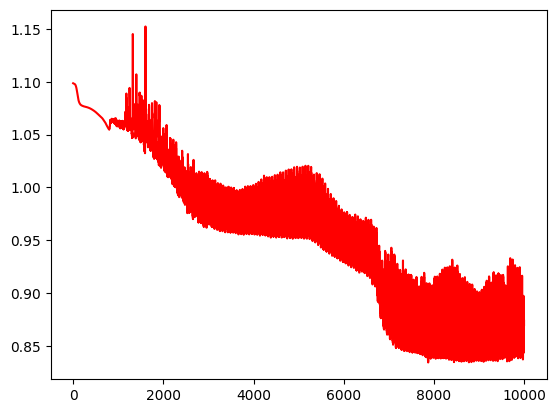

In [ ]:
# Driver Code for SGD(Red Curve)
# Create dataset
from matplotlib import pyplot as plt
loss_list1=[]
X, y = spiral_data(samples=100, classes=3)

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)
# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
optimizer = Optimizer_SGD(1,0,0)

#optimizer = Optimizer_Adam(learning_rate=0.05, decay=5e-7)
# Train in loop
for epoch in range(10001):

    # Perform a forward pass of our training data through this layer
    dense1.forward(X)

    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)

    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)

    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)
    loss_list1.append(loss)
    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions==y)

    if not epoch % 100:
        
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'lr: {optimizer.current_learning_rate}')

    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
x1=range(epoch+1)
plt.plot(x1,loss_list1,color='red')
#plt.plot(x1,loss_list1)

epoch: 0, acc: 0.343, loss: 1.099, lr: 0.001
epoch: 100, acc: 0.377, loss: 1.074, lr: 0.001
epoch: 200, acc: 0.397, loss: 1.069, lr: 0.001
epoch: 300, acc: 0.430, loss: 1.063, lr: 0.001
epoch: 400, acc: 0.443, loss: 1.054, lr: 0.001
epoch: 500, acc: 0.507, loss: 1.042, lr: 0.001
epoch: 600, acc: 0.507, loss: 1.022, lr: 0.001
epoch: 700, acc: 0.547, loss: 0.999, lr: 0.001
epoch: 800, acc: 0.553, loss: 0.975, lr: 0.001
epoch: 900, acc: 0.587, loss: 0.951, lr: 0.001
epoch: 1000, acc: 0.597, loss: 0.929, lr: 0.001
epoch: 1100, acc: 0.613, loss: 0.906, lr: 0.001
epoch: 1200, acc: 0.617, loss: 0.885, lr: 0.001
epoch: 1300, acc: 0.620, loss: 0.864, lr: 0.001
epoch: 1400, acc: 0.613, loss: 0.846, lr: 0.001
epoch: 1500, acc: 0.627, loss: 0.829, lr: 0.001
epoch: 1600, acc: 0.623, loss: 0.813, lr: 0.001
epoch: 1700, acc: 0.630, loss: 0.799, lr: 0.001
epoch: 1800, acc: 0.627, loss: 0.786, lr: 0.001
epoch: 1900, acc: 0.633, loss: 0.774, lr: 0.001
epoch: 2000, acc: 0.640, loss: 0.763, lr: 0.001
epoc

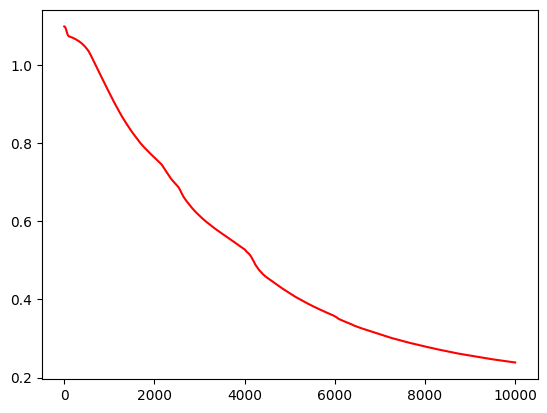

In [ ]:
# Driver Code for ADAM
# Create dataset
from matplotlib import pyplot as plt
loss_list2=[]
X, y = spiral_data(samples=100, classes=3)

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)
# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
optimizer = Optimizer_Adam()

#optimizer = Optimizer_Adam(learning_rate=0.05, decay=5e-7)
# Train in loop
for epoch in range(10001):

    # Perform a forward pass of our training data through this layer
    dense1.forward(X)

    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)

    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)

    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)
    loss_list2.append(loss)
    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions==y)

    if not epoch % 100:
        
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'lr: {optimizer.current_learning_rate}')

    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
x1=range(epoch+1)
plt.plot(x1,loss_list2,color='red')
#plt.plot(x1,loss_list1)

epoch: 0, acc: 0.317, loss: 1.099, lr: 0.001
epoch: 100, acc: 0.407, loss: 1.079, lr: 0.001
epoch: 200, acc: 0.420, loss: 1.073, lr: 0.001
epoch: 300, acc: 0.413, loss: 1.063, lr: 0.001
epoch: 400, acc: 0.447, loss: 1.048, lr: 0.001
epoch: 500, acc: 0.480, loss: 1.029, lr: 0.001
epoch: 600, acc: 0.503, loss: 1.008, lr: 0.001
epoch: 700, acc: 0.520, loss: 0.987, lr: 0.001
epoch: 800, acc: 0.553, loss: 0.965, lr: 0.001
epoch: 900, acc: 0.583, loss: 0.944, lr: 0.001
epoch: 1000, acc: 0.627, loss: 0.924, lr: 0.001
epoch: 1100, acc: 0.630, loss: 0.904, lr: 0.001
epoch: 1200, acc: 0.643, loss: 0.886, lr: 0.001
epoch: 1300, acc: 0.660, loss: 0.868, lr: 0.001
epoch: 1400, acc: 0.663, loss: 0.851, lr: 0.001
epoch: 1500, acc: 0.680, loss: 0.835, lr: 0.001
epoch: 1600, acc: 0.680, loss: 0.820, lr: 0.001
epoch: 1700, acc: 0.683, loss: 0.806, lr: 0.001
epoch: 1800, acc: 0.703, loss: 0.793, lr: 0.001
epoch: 1900, acc: 0.697, loss: 0.780, lr: 0.001
epoch: 2000, acc: 0.707, loss: 0.768, lr: 0.001
epoc

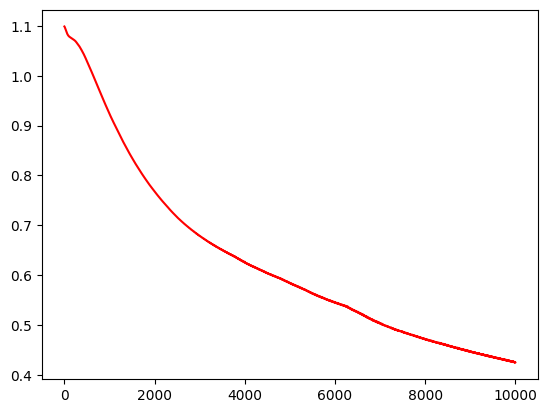

In [ ]:
# Driver Code for RMSprop
# Create dataset
from matplotlib import pyplot as plt
loss_list3=[]
X, y = spiral_data(samples=100, classes=3)

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)
# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
optimizer = Optimizer_RMSprop()

#optimizer = Optimizer_Adam(learning_rate=0.05, decay=5e-7)
# Train in loop
for epoch in range(10001):

    # Perform a forward pass of our training data through this layer
    dense1.forward(X)

    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)

    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)

    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)
    loss_list3.append(loss)
    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions==y)

    if not epoch % 100:
        
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'lr: {optimizer.current_learning_rate}')

    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
x1=range(epoch+1)
plt.plot(x1,loss_list3,color='red')

epoch: 0, acc: 0.353, loss: 1.099, lr: 1.0
epoch: 100, acc: 0.490, loss: 0.983, lr: 1.0
epoch: 200, acc: 0.513, loss: 0.942, lr: 1.0
epoch: 300, acc: 0.520, loss: 0.919, lr: 1.0
epoch: 400, acc: 0.520, loss: 0.906, lr: 1.0
epoch: 500, acc: 0.543, loss: 0.887, lr: 1.0
epoch: 600, acc: 0.550, loss: 0.870, lr: 1.0
epoch: 700, acc: 0.537, loss: 0.875, lr: 1.0
epoch: 800, acc: 0.607, loss: 0.859, lr: 1.0
epoch: 900, acc: 0.567, loss: 0.841, lr: 1.0
epoch: 1000, acc: 0.630, loss: 0.843, lr: 1.0
epoch: 1100, acc: 0.580, loss: 0.830, lr: 1.0
epoch: 1200, acc: 0.633, loss: 0.826, lr: 1.0
epoch: 1300, acc: 0.603, loss: 0.812, lr: 1.0
epoch: 1400, acc: 0.640, loss: 0.821, lr: 1.0
epoch: 1500, acc: 0.620, loss: 0.803, lr: 1.0
epoch: 1600, acc: 0.607, loss: 0.789, lr: 1.0
epoch: 1700, acc: 0.680, loss: 0.782, lr: 1.0
epoch: 1800, acc: 0.640, loss: 0.785, lr: 1.0
epoch: 1900, acc: 0.633, loss: 0.784, lr: 1.0
epoch: 2000, acc: 0.633, loss: 0.755, lr: 1.0
epoch: 2100, acc: 0.690, loss: 0.725, lr: 1.0


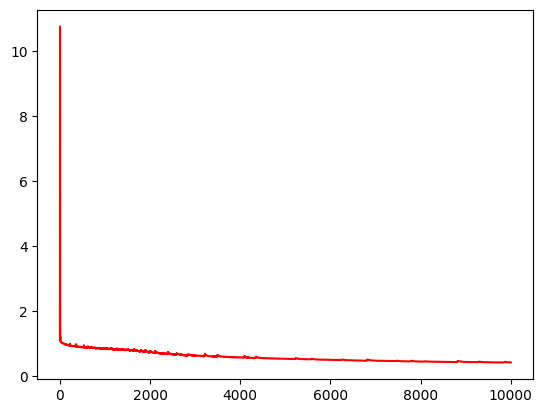

In [ ]:
# Driver Code for ADAGRAD
# Create dataset
from matplotlib import pyplot as plt
loss_list4=[]
X, y = spiral_data(samples=100, classes=3)

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)
# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
optimizer = Optimizer_Adagrad()

#optimizer = Optimizer_Adam(learning_rate=0.05, decay=5e-7)
# Train in loop
for epoch in range(10001):

    # Perform a forward pass of our training data through this layer
    dense1.forward(X)

    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)

    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)

    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)
    loss_list4.append(loss)
    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions==y)

    if not epoch % 100:
        
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'lr: {optimizer.current_learning_rate}')

    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
x1=range(epoch+1)
plt.plot(x1,loss_list4,color='red')

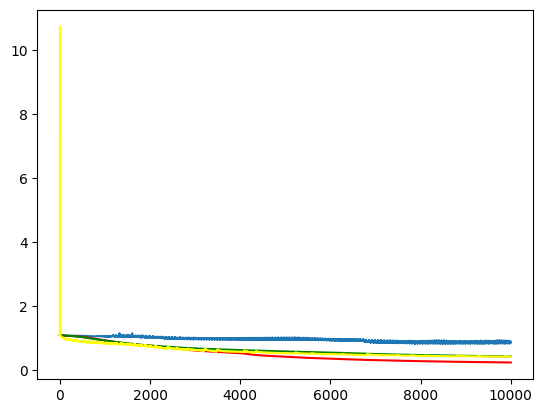

In [ ]:
plt.plot(x1,loss_list1) #sgd
plt.plot(x1,loss_list2,color='red') #adam
plt.plot(x1,loss_list3,color='green') #rmsprop
plt.plot(x1,loss_list4,color='yellow') #adagrad